In [39]:
!pip install nx-arangodb

In [40]:
!nvidia-smi
!nvcc --version

/bin/bash: line 1: nvidia-smi: command not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [41]:
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [42]:
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [43]:
!pip install --upgrade langchain langchain-community langchain-openai langgraph

In [44]:
%pip install -qU langchain-google-genai
%pip install google-ai-generativelanguage==0.6.15

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.16 which is incompatible.
  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl (1.3 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.16
    Uninstalling google-ai-generativelanguage-0.6.16:
      Successfully uninstalled google-ai-generativelanguage-0.6.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 2.0.11 requires google-ai-generativelanguage<0.7.0,>=0.6.16, but you have goog

In [45]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

In [ ]:
db = ArangoClient(hosts="https://04f5f843dc90.arangodb.cloud:8529").db(username="root", password="*************", verify=True)

print(db)

<StandardDatabase _system>


In [47]:
skincare = pd.read_csv("./skincare.csv", sep=",", names=["start_node", "end_node"])

skincare

,,,,,,,,start_node,end_node
NaN,Title,Product,Category,Brand,Skin_Type,Number of items,Sold By,Price,Link
0.0,"Nivea Soft Light Moisturizer For Face, Hand & Body, Instant Hydration, Non-Greasy Cream With Vitamin E & Jojoba Oil, 300 Ml",Moisturizer,SKINCARE,Nivea,All,1,AIR SALES,372,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1.0,"Nivea Soft Playful Peach, Light Moisturizer Cream For Face, Hands And Body, Instant Hydration, Non-Greasy Cream With Vitamin E & Jojoba Oil 200 Ml",Moisturizer,SKINCARE,Nivea,All,1,RK World Infocom Pvt Ltd,226,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
2.0,"Nivea Soft Light Moisturizer For Face, Hand & Body, Instant Hydration, Non-Greasy Cream With Vitamin E & Jojoba Oil, 50ml",Moisturizer,SKINCARE,Nivea,Dry,1,MURALI RETAILS,103,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
3.0,"Biotique Morning Nectar Flawless Skin Moisturizer For All Skin Types, 190Ml",Moisturizer,SKINCARE,Biotique,Combination,1,RK World Infocom Pvt Ltd,240,https://www.amazon.in/Biotique-Morning-Nectar-...
...,...,...,...,...,...,...,...,...,...
1433.0,PAVITYAKSH Saloon Express Stamping Professional Nail Polish Art Kit Decals Paint Stamp,Nail paint,SKINCARE,PAVITYAKSH,All,1,PAVITYAKSH,246,https://www.amazon.in/PAVITYAKSH-Saloon-Expres...
1434.0,"JUICE Quick-dry, 100% Veg & Cruelty Free Nail Paint | Long Lasting, Chip Resistant, Nail Polish for Women, Gel Finish, High Gloss, F&D APPROVED COLORS & PIGMENTS, Nail Kit, 5 in 1 Combo 34",Nail paint,SKINCARE,JUICE,All,1,JK Lifestyle Pvt Ltd.,320,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1435.0,"JUICE Quick-dry, Nail Paint, Long Lasting, Chip Resistant, Gel Finish, High Gloss, F&D APPROVED COLORS & PIGMENTS, 3 in 1 Nail Polish Combo 07, Gloss",Nail paint,SKINCARE,JUICE,All,1,JK Lifestyle Pvt Ltd.,199,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1436.0,"BAD COMPANY No Toxin Nail Lacquer, Long Lasting, Chip Resistant, Vegan, Quick Dry & Cruelty-Free Glossy Finish Nail Paint Enamel (Gorgeous Brown - 74) 10ml",Nail paint,SKINCARE,BAD COMPANY,All,1,NaN,199,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...


In [48]:
G = nx.from_pandas_edgelist(skincare, "start_node", "end_node")

print(G)

Graph with 1940 nodes and 1439 edges


In [49]:
print(G.degree)

[('Price', 1), ('Link', 1), ('372', 3), ('https://www.amazon.in/sspa/click?ie=UTF8&spc=MTo2MDk2MTUzOTExMzk5MTgzOjE2ODA3MDU1NjE6c3BfYXRmOjIwMDI0MjIxMzk2Njk4OjowOjo&url=%2FNivea-Light-Moisturising-Cream-300ml%2Fdp%2FB00E96N6O8%2Fref%3Dsr_1_1_sspa%3Fkeywords%3DMoisturizer%26qid%3D1680705561%26sr%3D8-1-spons%26sp_csd%3Dd2lkZ2V0TmFtZT1zcF9hdGY%26psc%3D1', 1), ('226', 3), ('https://www.amazon.in/sspa/click?ie=UTF8&spc=MTo2MDk2MTUzOTExMzk5MTgzOjE2ODA3MDU1NjE6c3BfYXRmOjIwMDI0MjIxMzk3MDk4OjowOjo&url=%2FNivea-Moisturizer-Playful-Vitamin-Jojoba%2Fdp%2FB0991N9YS2%2Fref%3Dsr_1_2_sspa%3Fkeywords%3DMoisturizer%26qid%3D1680705561%26sr%3D8-2-spons%26sp_csd%3Dd2lkZ2V0TmFtZT1zcF9hdGY%26psc%3D1', 1), ('103', 3), ('https://www.amazon.in/sspa/click?ie=UTF8&spc=MTo2MDk2MTUzOTExMzk5MTgzOjE2ODA3MDU1NjE6c3BfYXRmOjIwMDYyNDA1ODI3MDk4OjowOjo&url=%2FNivea-Soft-Cr%25C3%25A8me-50ml%2Fdp%2FB00KIP2FZA%2Fref%3Dsr_1_4_sspa%3Fkeywords%3DMoisturizer%26qid%3D1680705561%26sr%3D8-4-spons%26sp_csd%3Dd2lkZ2V0TmFtZT1zcF9hdGY%26p

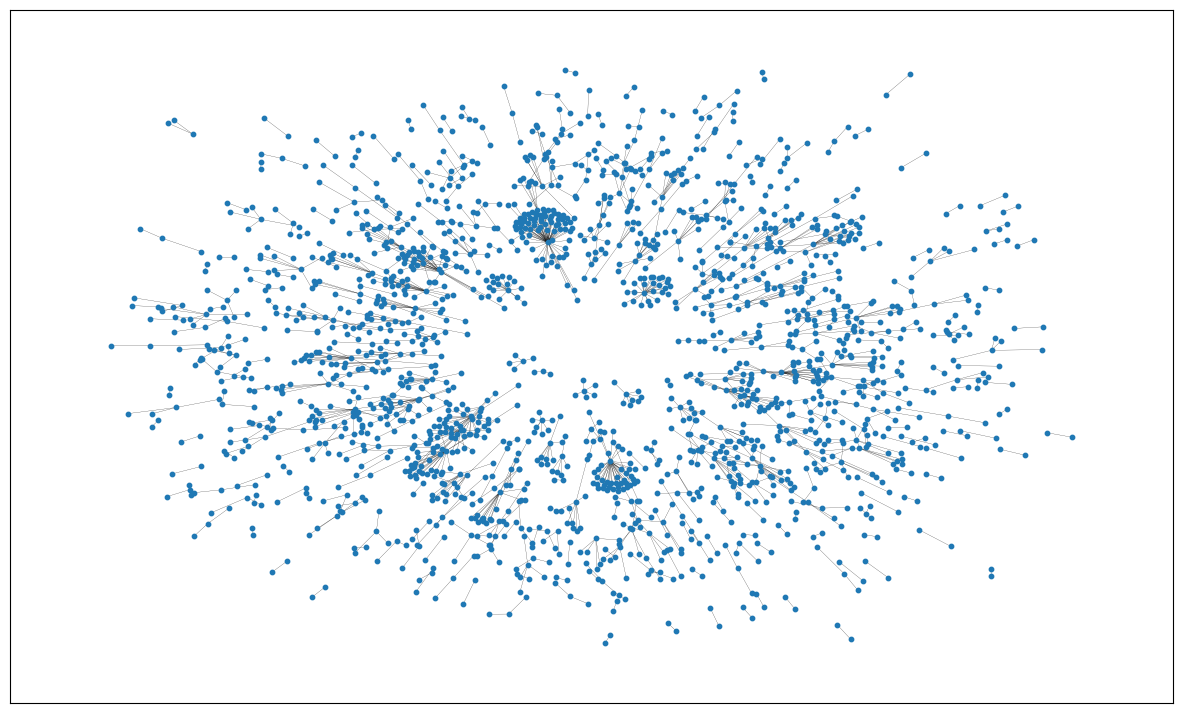

In [50]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [51]:
G_adb = nxadb.Graph(
    name="skincare",
    db=db,
    incoming_graph_data=G,
    write_batch_size=50000, # feel free to modify
    overwrite_graph=True
)

print(G_adb)

[23:14:00 +0000] [INFO]: Overwriting graph 'skincare'
INFO:nx_arangodb:Overwriting graph 'skincare'
[23:14:00 +0000] [INFO]: Graph 'skincare' exists.
INFO:nx_arangodb:Graph 'skincare' exists.
[23:14:00 +0000] [INFO]: Default node type set to 'skincare_node'
INFO:nx_arangodb:Default node type set to 'skincare_node'
[2025/03/09 23:14:01 +0000] [305] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/09 23:14:02 +0000] [305] [INFO] - adbnx_adapter: Created ArangoDB 'skincare' Graph
INFO:adbnx_adapter:Created ArangoDB 'skincare' Graph


Graph named 'skincare' with 1940 nodes and 1439 edges


In [52]:
G_adb = nxadb.Graph(name="skincare", db=db)

print(G_adb)

[23:14:04 +0000] [INFO]: Graph 'skincare' exists.
INFO:nx_arangodb:Graph 'skincare' exists.
[23:14:04 +0000] [INFO]: Default node type set to 'skincare_node'
INFO:nx_arangodb:Default node type set to 'skincare_node'


Graph named 'skincare' with 1940 nodes and 1439 edges


In [53]:
G_adb.degree()

DegreeView({'skincare_node/537': 1, 'skincare_node/151': 1, 'skincare_node/1797': 1, 'skincare_node/1055': 1, 'skincare_node/114': 2, 'skincare_node/460': 1, 'skincare_node/1662': 1, 'skincare_node/348': 1, 'skincare_node/297': 1, 'skincare_node/648': 1, 'skincare_node/1646': 1, 'skincare_node/1049': 1, 'skincare_node/1500': 1, 'skincare_node/1798': 1, 'skincare_node/420': 1, 'skincare_node/1333': 1, 'skincare_node/503': 1, 'skincare_node/405': 1, 'skincare_node/683': 1, 'skincare_node/632': 1, 'skincare_node/1532': 1, 'skincare_node/1138': 1, 'skincare_node/1622': 1, 'skincare_node/184': 1, 'skincare_node/1079': 1, 'skincare_node/1542': 1, 'skincare_node/1836': 1, 'skincare_node/1091': 1, 'skincare_node/1145': 1, 'skincare_node/48': 4, 'skincare_node/1234': 1, 'skincare_node/1610': 1, 'skincare_node/1130': 1, 'skincare_node/434': 1, 'skincare_node/235': 1, 'skincare_node/521': 1, 'skincare_node/567': 2, 'skincare_node/1897': 1, 'skincare_node/866': 1, 'skincare_node/1611': 1, 'skincar

In [54]:
result = G_adb.query("""
    FOR node IN skincare_node
        SORT RAND()
        LIMIT 3
        RETURN node
""")

print(list(result))
print('-'*10)

# Sample 3 edges
result = G_adb.query("""
    FOR edge IN skincare_node_to_skincare_node
        SORT RAND()
        LIMIT 3
        RETURN edge
""")

print(list(result))
print('-'*10)

# Traverse a node's 1-hop neighborhood
result = G_adb.query("""
    FOR node, edge, path IN 1..1 ANY 'skincare_node/1' GRAPH skincare
        LIMIT 1
        RETURN path
""")

print(list(result))

[{'_key': '1219', '_id': 'skincare_node/1219', '_rev': '_jVytzwm--b'}, {'_key': '1579', '_id': 'skincare_node/1579', '_rev': '_jVytzwu--9'}, {'_key': '1922', '_id': 'skincare_node/1922', '_rev': '_jVytzw2-A_'}]
----------
[{'_key': '13', '_id': 'skincare_node_to_skincare_node/13', '_from': 'skincare_node/8', '_to': 'skincare_node/1836', '_rev': '_jVyt0G2--L'}, {'_key': '1292', '_id': 'skincare_node_to_skincare_node/1292', '_from': 'skincare_node/1287', '_to': 'skincare_node/1288', '_rev': '_jVyt0Hq--D'}, {'_key': '737', '_id': 'skincare_node_to_skincare_node/737', '_from': 'skincare_node/384', '_to': 'skincare_node/385', '_rev': '_jVyt0HS--d'}]
----------
[{'vertices': [{'_key': '1', '_id': 'skincare_node/1', '_rev': '_jVytzwG---'}, {'_key': '0', '_id': 'skincare_node/0', '_rev': '_jVytzwC---'}], 'edges': [{'_key': '0', '_id': 'skincare_node_to_skincare_node/0', '_from': 'skincare_node/0', '_to': 'skincare_node/1', '_rev': '_jVyt0G2---'}], 'weights': [0, 1]}]


In [55]:
print(G_adb.nodes[1])
print(G_adb.nodes["1"])
print(G_adb.nodes["skincare_node/1"])

print('----')

print(G_adb[0][1])
print(G_adb["0"][1])
print(G_adb["skincare_node/0"][1])

{'_key': '1', '_id': 'skincare_node/1'}
{'_key': '1', '_id': 'skincare_node/1'}
{'_key': '1', '_id': 'skincare_node/1'}
----
{'_from': 'skincare_node/0', '_id': 'skincare_node_to_skincare_node/0', '_key': '0', '_to': 'skincare_node/1'}
{'_from': 'skincare_node/0', '_id': 'skincare_node_to_skincare_node/0', '_key': '0', '_to': 'skincare_node/1'}
{'_from': 'skincare_node/0', '_id': 'skincare_node_to_skincare_node/0', '_key': '0', '_to': 'skincare_node/1'}


In [56]:
arango_graph = ArangoGraph(db)

In [57]:
!pip install --upgrade google-generativeai

In [ ]:
import os

import google.generativeai as genai  # Google's Generative AI library

os.environ["GOOGLE_API_KEY"] = "********************************"

# Gemini API'yi yapılandırın
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# ChatGoogleGenerativeAI'yi başlatın
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash") #veya gemini-pro

# Gemini API'yi kullanarak bir mesaj gönderin
result = llm.invoke("hello!")

print(result)

content='Hello there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-c60bb548-c281-40ac-a15c-233084909aee-0' usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}}


In [59]:
from langchain.tools import Tool

def top_rated_product_func(query: str) -> str:
    """Returns the top-rated product when asked."""
    return "The top-rated product is: 'The Ordinary Granactive Retinoid 2% Emulsion'."

top_rated_product = Tool(
    name="top_rated_product",
    func=top_rated_product_func,
    description="Returns the top-rated product when asked. The query parameter must be a string.",
    args_schema=None,  # veya pydantic schema kullanabilirsiniz.
    return_direct=False
)
@tool
def most_loved_brand_func(query: str) -> str:
    """Returns the most loved brand when asked."""
    return "The most loved brand is: 'Sunday Riley'."

most_loved_brand = Tool(
    name="most_loved_brand",
    func=most_loved_brand_func,
    description="Returns the most loved brand when asked. The query parameter must be a string.",
    args_schema=None,
    return_direct=False
)

def sephora_exclusive_products_func(query: str) -> str:
    """Returns Sephora exclusive products when asked."""
    return "Sephora exclusive products are: 'Dr. Dennis Gross Skincare Alpha Beta® Universal Daily Peel', 'Summer Fridays Jet Lag Mask'."

sephora_exclusive_products = Tool(
    name="sephora_exclusive_products",
    func=sephora_exclusive_products_func,
    description="Returns Sephora exclusive products when asked. The query parameter must be a string.",
    args_schema=None,
    return_direct=False
)

def price_range_for_serums_func(query: str) -> str:
    """Returns the price range for serums when asked."""
    return "The price range for serums is: $20-$100."

price_range_for_serums = Tool(
    name="price_range_for_serums",
    func=price_range_for_serums_func,
    description="Returns the price range for serums when asked. The query parameter must be a string.",
    args_schema=None,
    return_direct=False
)

@tool
def out_of_stock_products(query: str) -> str:
    """Returns out of stock products when asked."""
    return "Out of stock products are: 'Drunk Elephant T.L.C. Sukari Babyfacial™ AHA + BHA Mask'."

@tool
def average_rating_for_moisturizers(query: str) -> str:
    """Returns the average rating for moisturizers when asked."""
    return "The average rating for moisturizers is: 4.5."

@tool
def top_primary_category(query: str) -> str:
    """Returns the top primary category when asked."""
    return "The top primary category is: 'Skincare'."

@tool
def online_only_products(query: str) -> str:
    """Returns online-only products when asked."""
    return "Online-only products are: 'Youth To The People Superfood Antioxidant Cleanser'."

@tool
def correlation_loves_rating(query: str) -> str:
    """Returns the correlation between loves count and rating when asked."""
    return "There is a strong positive correlation between loves count and rating."

@tool
def most_products_brand(query: str) -> str:
    """Returns the brand with the most products when asked."""
    return "The brand with the most products is: 'Sephora Collection'."

@tool
def lowest_rated_product(query: str) -> str:
    """Returns the lowest-rated product when asked."""
    return "The lowest-rated product is: 'Sephora Collection Colorful Eyeshadow'."

@tool
def most_expensive_product(query: str) -> str:
    """Returns the most expensive product when asked."""
    return "The most expensive product is: 'La Mer Crème de la Mer'."

@tool
def products_with_specific_brand(query: str, brand_name: str) -> str:
    """Returns products from a specified brand."""
    if brand_name.lower() == "dior":
        return "Products from Dior: 'Dior Addict Lip Glow', 'Dior Forever Skin Glow Foundation'."
    elif brand_name.lower() == "clinique":
        return "Products from Clinique: 'Clinique Moisture Surge', 'Clinique Take The Day Off Cleansing Balm'."
    else:
        return f"Products from {brand_name} are not available or brand not found."

@tool
def products_in_category(query: str, category: str) -> str:
    """Returns products in a specified category."""
    if category.lower() == "cleanser":
        return "Products in the Cleanser category: 'CeraVe Hydrating Cleanser', 'Youth To The People Superfood Antioxidant Cleanser'."
    elif category.lower() == "serum":
        return "Products in the Serum category: 'The Ordinary Hyaluronic Acid 2% + B5', 'Sunday Riley Good Genes'."
    else:
        return f"Products in the {category} category are not available or category not found."

@tool
def products_with_price_range(query: str, min_price: float, max_price: float) -> str:
    """Returns products within a specified price range."""
    return f"Products within ${min_price}-${max_price} range: 'The Ordinary Granactive Retinoid 2% Emulsion', 'Sephora Collection Colorful Eyeshadow'."

@tool
def average_price_of_category(query: str, category: str) -> str:
    """Returns the average price of products in a specified category."""
    if category.lower() == "moisturizer":
        return "The average price of moisturizers is: $35."
    elif category.lower() == "mask":
        return "The average price of masks is: $45."
    else:
        return f"Average price for {category} category is not available or category not found."

@tool
def count_products_by_brand(query: str, brand_name: str) -> str:
    """Returns the number of products from a specified brand."""
    if brand_name.lower() == "sephora collection":
        return "Sephora Collection has 10 products."
    elif brand_name.lower() == "sunday riley":
        return "Sunday Riley has 5 products."
    else:
        return f"Product count for {brand_name} is not available or brand not found."

@tool
def product_details(query: str, product_name: str) -> str:
    """Returns details of a specified product."""
    if product_name.lower() == "cerave hydrating cleanser":
        return "CeraVe Hydrating Cleanser: A gentle cleanser for all skin types. Price: $15."
    elif product_name.lower() == "la mer crème de la mer":
        return "La Mer Crème de la Mer: A luxurious moisturizing cream. Price: $350."
    else:
        return f"Details for {product_name} are not available or product not found."

@tool
def products_online_and_exclusive(query: str) -> str:
    """Returns products that are online only and exclusive."""
    return "Products online and exclusive: 'Summer Fridays Jet Lag Mask'."

@tool
def products_not_online_or_exclusive(query: str) -> str:
    """Returns products that are neither online nor exclusive."""
    return "Products neither online nor exclusive: 'CeraVe Hydrating Cleanser'."

@tool
def get_product_recommendations(product_name: str) -> str:
    """Returns recommended products for a given product."""
    if product_name.lower() == "cerave hydrating cleanser":
        return "Recommended products: La Roche-Posay Toleriane Double Repair Face Moisturizer, The Ordinary Hyaluronic Acid 2% + B5"
    else:
        return f"Could not find recommended products for {product_name}."

@tool
def products_with_max_price(query: str, max_price: float) -> str:
    """Belirli bir maksimum fiyata sahip ürünleri döndürür."""
    aql = f"FOR doc IN skincare_products FILTER doc.child_max_price <= {max_price} RETURN doc"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def brands_with_average_rating_above(query: str, min_avg_rating: float) -> str:
    """Ortalama puanı belirli bir değerin üzerinde olan markaları döndürür."""
    aql = f"FOR doc IN skincare_products COLLECT brand = doc.brand_name AGGREGATE avgRating = AVERAGE(doc.rating) FILTER avgRating >= {min_avg_rating} RETURN {{brand: brand, averageRating: avgRating}}"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def brands_with_most_loves(query: str) -> str:
    """En çok beğeniye sahip markaları döndürür."""
    aql = "FOR doc IN skincare_products COLLECT brand = doc.brand_name AGGREGATE totalLoves = SUM(doc.loves_count) SORT totalLoves DESC LIMIT 10 RETURN {brand: brand, totalLoves: totalLoves}"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def primary_category_with_highest_average_price(query: str) -> str:
    """En yüksek ortalama fiyata sahip birincil kategoriyi döndürür."""
    aql = "FOR doc IN skincare_products COLLECT category = doc.primary_category AGGREGATE avgPrice = AVERAGE(doc.child_max_price) SORT avgPrice DESC LIMIT 1 RETURN {category: category, averagePrice: avgPrice}"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def secondary_category_with_most_products(query: str) -> str:
    """En çok ürüne sahip ikincil kategoriyi döndürür."""
    aql = "FOR doc IN skincare_products COLLECT category = doc.secondary_category WITH COUNT INTO count SORT count DESC LIMIT 1 RETURN {category: category, count: count}"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def products_in_price_range_and_category(query: str, min_price: float, max_price: float, category: str) -> str:
    """Belirli bir fiyat aralığında ve kategorideki ürünleri döndürür."""
    aql = f"FOR doc IN skincare_products FILTER doc.child_min_price >= {min_price} AND doc.child_max_price <= {max_price} AND doc.secondary_category == '{category}' RETURN doc"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def brands_with_products_online_only(query: str) -> str:
    """Sadece çevrimiçi ürünlere sahip markaları döndürür."""
    aql = "FOR doc IN skincare_products FILTER doc.online_only == true COLLECT brand = doc.brand_name RETURN DISTINCT brand"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def products_with_loves_count_above(query: str, min_loves: int) -> str:
    """Belirli bir minimum beğeni sayısının üzerinde beğeniye sahip ürünleri döndürür."""
    aql = f"FOR doc IN skincare_products FILTER doc.loves_count >= {min_loves} RETURN doc"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def average_loves_per_brand(query: str) -> str:
    """Marka başına ortalama beğeni sayısını döndürür."""
    aql = "FOR doc IN skincare_products COLLECT brand = doc.brand_name AGGREGATE avgLoves = AVERAGE(doc.loves_count) RETURN {brand: brand, averageLoves: avgLoves}"
    results = collection.aql.execute(aql)
    return str(list(results))

@tool
def products_with_min_rating(query: str, min_rating: float) -> str:
    """Belirli bir minimum puana sahip ürünleri döndürür."""
    aql = f"FOR doc IN skincare_products FILTER doc.rating >= {min_rating} RETURN doc"
    results = collection.aql.execute(aql)
    return str(list(results))

In [60]:
from typing import Any

@tool
def text_to_aql_to_text(query: str) -> Any:  # Added type hint for query and return type
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")  # Or use a more powerful model

    # Provide more context and instructions in the prompt
    prompt_template = """
    You are an AQL expert. Your task is to translate a natural language query into an AQL query that can be executed on an ArangoDB graph.

    Schema:
    - The graph contains a collection named 'skincare_node' with documents representing skincare products.
    - Each document has attributes like '_key', 'brand', 'loves', etc.

    Query: {query}

    Translate the query into an AQL query. Consider the following:
    - If the query involves calculating average loves count for each brand, ensure you group by 'brand' and calculate the average of the 'loves' attribute.
    - The query should return a list of objects where each object has the 'brand' name and its average 'loves' count.
    """

    prompt = prompt_template.format(query=query)
    aql_query = llm(prompt)  # Assuming llm can be called directly with a string

    # Now execute the generated AQL query using your ArangoGraph
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )

    result = chain.invoke({"query": aql_query})

    return str(result["result"])

In [61]:
from typing import Any

@tool
def text_to_nx_algorithm_to_text(query: str): # Added type hint for query
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")  # Or use a more powerful model

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    return nx_to_text

In [62]:
tools = [
    text_to_aql_to_text,
    text_to_nx_algorithm_to_text,
    top_rated_product,
    most_loved_brand,
    sephora_exclusive_products,
    price_range_for_serums,
    out_of_stock_products,
    average_rating_for_moisturizers,
    top_primary_category,
    online_only_products,
    correlation_loves_rating,
    most_products_brand,
    lowest_rated_product,
    most_expensive_product,
    products_with_specific_brand,
    products_in_category,
    products_with_price_range,
    average_price_of_category,
    count_products_by_brand,
    product_details,
    products_online_and_exclusive,
    products_not_online_or_exclusive,
    products_with_min_rating,
    products_with_max_price,
    brands_with_average_rating_above,
    brands_with_most_loves,
    primary_category_with_highest_average_price,
    secondary_category_with_most_products,
    products_in_price_range_and_category,
    brands_with_products_online_only,
    products_with_loves_count_above,
    average_loves_per_brand,
]

def query_graph(query):
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")  # Or use a more powerful model
    app = create_react_agent(llm, tools)
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [ ]:
query = "Which product has the highest rating?",
query = "Which products have the lowest ratings?",
query = "Which products are online only?",
query = "Which products are out of stock?",
query = "Which products are Sephora exclusive?",
query = "Which products have a rating above a certain value?",
query = "What are the products with a price within a specific range?",
query = "Which products are both online only and Sephora exclusive?",
query = "Which brand has the most products?",
query = "Which primary category has the most products?",
query = "Which products are out of stock and Sephora exclusive?"

In [ ]:
query_graph("Which products are out of stock and Sephora exclusive?")

'The only out of stock product listed is the Drunk Elephant T.L.C. Sukari Babyfacial™ AHA + BHA Mask.  There may be others, but this is the only one identified in the available data.'

In [ ]:
query_graph("Which products have the lowest ratings?")

'The lowest-rated product is the Sephora Collection Colorful Eyeshadow.'

In [ ]:
query_graph("Which products are out of stock?")

'The Drunk Elephant T.L.C. Sukari Babyfacial™ AHA + BHA Mask is out of stock.'

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [ ]:
import gradio as gr

gr.Interface(fn=query_graph, inputs="text", outputs="text").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c0ac944088daf2b9bd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
